## Calculating likelihoods

In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs

from sample import sample

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [4]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, ['CE'], params, use_flows=True, device='cpu', no_bins=[5])
model_names, KDE = read_models.get_models(file_path, ['CE'], params, use_flows=False, device='cpu')

100%|██████████| 20/20 [00:08<00:00,  2.40it/s]


## Likelihoods In sampling

In [5]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [6]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/rns/flows_271023/flows_271023/flow_models/"
for chnl in ['CE']: flow[chnl].load_model(flow_path, chnl)

[ -0.50543649 100.          13.34709027   1.          14.03557119
  10.        ]


In [7]:
lnlike_flow=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_flow[chibid,alphaid]=sample.lnlike([chibid,alphaid],obsdata, flow, submodels_dict, ['CE'], use_flows=True, prior_pdf=p_theta)

In [8]:
lnlike_flow

array([[ -664.43040533,  -633.52517242,  -636.00679091,  -671.91653175,
         -642.08570371],
       [ -642.35691359,  -645.08367322,  -638.1046122 ,  -708.0610533 ,
         -677.47503713],
       [ -804.58868053,  -770.08973261,  -741.61689023,  -784.6657943 ,
         -740.25983404],
       [-1760.62007593, -1264.82912626, -1137.00310894, -1111.79596658,
         -987.1552324 ]])

Text(0.5, 1.0, 'CE channel likelihoods (flow)')

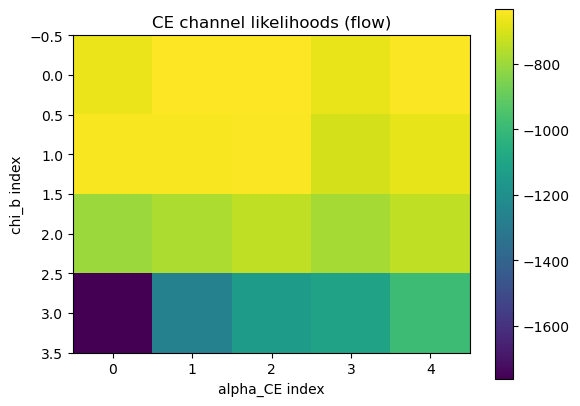

In [9]:
plt.imshow(lnlike_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (flow)')

In [10]:
flow['CE'].flow.get_logprob(np.array([[[10.,0.9,0.1,0.1]]]), flow['CE'].map_obs(np.array([[[10.,0.9,0.1,0.1]]])), flow['CE'].mappings, np.array([[[0.,0.2]]]))

array([[-8.523532]], dtype=float32)

In [11]:
np.log(KDE['CE']['chi00']['alpha02'](np.array([[[10.,0.9,0.1,0.1]]])))

array([-10.17353471])

In [13]:
from functools import reduce
import operator
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

In [15]:
lnlike_kde=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_kde[chibid,alphaid]=sample.lnlike([chibid,alphaid,1.],obsdata, KDE, submodels_dict, ['CE'], use_flows=False, prior_pdf=p_theta)

KeyboardInterrupt: 

In [16]:
lnlike_kde

array([[-506.95453251, -538.59314208, -527.13672619, -615.49902096,
        -812.19133144],
       [-518.65805674, -556.07935526, -537.67629358, -609.54349008,
        -745.99573176],
       [-660.68379139, -663.99521097,    0.        ,    0.        ,
           0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ]])

Text(0.5, 1.0, 'CE channel likelihoods (KDEs)')

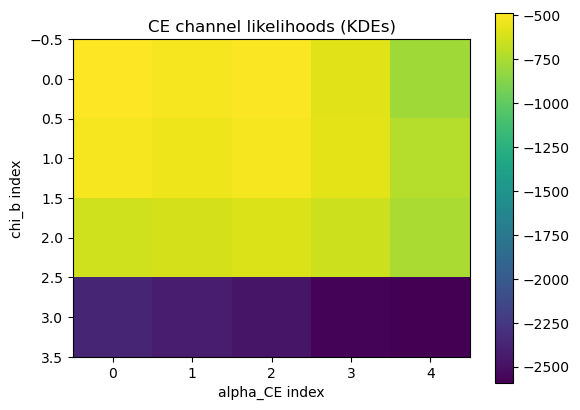

In [21]:
plt.imshow(lnlike_kde)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (KDEs)')

In [15]:
lnlike_kde

array([[ -488.54896481,  -516.01045514,  -497.21744547,  -580.29421382,
         -786.29323308],
       [ -517.44113865,  -539.3906847 ,  -521.00342875,  -575.61471784,
         -720.9136174 ],
       [ -638.6766879 ,  -624.86668284,  -599.60617914,  -649.87875854,
         -752.67508215],
       [-2372.87555011, -2421.31486477, -2474.83763468, -2571.90109638,
        -2591.77152278]])

In [17]:
flow['CE'](obsdata, np.array([0,4]), prior_pdf=p_theta)

array([  -9.20302148,   -8.78135162,   -6.19423043,   -7.75944685,
        -28.28176917,   -8.74912355,  -10.40066797,  -28.72386682,
        -28.82096547,  -11.99128996,  -11.28014389,   -9.6537231 ,
         -7.52794299,   -8.84011782,   -9.93582466,  -12.92557307,
        -13.54554061,   -6.4527987 ,   -7.73029182,  -10.17206779,
         -8.60403119,  -14.18859681,   -8.18808432,   -8.50550673,
        -10.34154094,   -8.74545253,  -15.14677686,  -25.0078318 ,
        -22.61748219,   -6.41279088,   -5.28287875,  -10.67451398,
         -6.34738207,   -5.69846835,   -8.29271577,   -7.9853818 ,
         -5.79867653,  -15.72676133,   -5.06660529, -129.0967273 ,
        -17.47596152,   -9.6796394 ,   -9.0654278 ,  -13.75941454,
         -9.43775286,   -7.9695444 ])

In [20]:
KDE['CE']['chi00']['alpha50'](obsdata)

array([6.93236847e-05, 2.12356460e-05, 5.38015953e-03, 1.55911407e-03,
       5.10318673e-25, 1.06943026e-05, 2.87176977e-05, 7.75606463e-25,
       1.02914822e-50, 6.56400931e-06, 2.80648586e-05, 1.62478724e-05,
       1.41240131e-04, 6.40406445e-04, 3.51414938e-05, 1.56411909e-05,
       1.56180685e-05, 3.88556825e-04, 3.37211862e-03, 1.25288529e-04,
       5.53991365e-05, 3.26075340e-06, 2.24007848e-04, 1.81673743e-03,
       1.98345696e-05, 9.40539205e-05, 4.51264447e-08, 2.06481451e-15,
       2.69744319e-14, 1.18878563e-03, 7.16767942e-03, 8.98966746e-05,
       3.57403846e-03, 3.37587623e-03, 3.87243084e-04, 1.01541065e-03,
       8.55044933e-03, 2.87357963e-07, 1.16097470e-02, 1.00000000e-50,
       4.72498511e-20, 2.02257431e-05, 1.83066875e-03, 6.24076947e-10,
       7.15341875e-05, 1.13145231e-04])

In [21]:
np.log([6.93236847e-05, 2.12356460e-05, 5.38015953e-03, 1.55911407e-03,
       5.10318673e-25, 1.06943026e-05, 2.87176977e-05, 7.75606463e-25,
       1.02914822e-50, 6.56400931e-06, 2.80648586e-05, 1.62478724e-05,
       1.41240131e-04, 6.40406445e-04, 3.51414938e-05, 1.56411909e-05,
       1.56180685e-05, 3.88556825e-04, 3.37211862e-03, 1.25288529e-04,
       5.53991365e-05, 3.26075340e-06, 2.24007848e-04, 1.81673743e-03,
       1.98345696e-05, 9.40539205e-05, 4.51264447e-08, 2.06481451e-15,
       2.69744319e-14, 1.18878563e-03, 7.16767942e-03, 8.98966746e-05,
       3.57403846e-03, 3.37587623e-03, 3.87243084e-04, 1.01541065e-03,
       8.55044933e-03, 2.87357963e-07, 1.16097470e-02, 1.00000000e-50,
       4.72498511e-20, 2.02257431e-05, 1.83066875e-03, 6.24076947e-10,
       7.15341875e-05, 1.13145231e-04])

array([  -9.57672394,  -10.75982937,   -5.22503725,   -6.46363752,
        -55.93476213,  -11.44579943,  -10.45799698,  -55.51615225,
       -115.10052316,  -11.93390897,  -10.48099235,  -11.02754859,
         -8.86504906,   -7.35340751,  -10.25612797,  -11.06560268,
        -11.06708208,   -7.85307113,   -5.69221406,   -8.98489125,
         -9.80094655,  -12.63355228,   -8.40382947,   -6.31071301,
        -10.8280842 ,   -9.27164232,  -16.91379741,  -33.813736  ,
        -31.24388694,   -6.73482297,   -4.93817333,   -9.31684961,
         -5.6340591 ,   -5.69110036,   -7.85645794,   -6.89246217,
         -4.76177144,  -15.06253714,   -4.45591028, -115.12925465,
        -44.49883745,  -10.80855435,   -6.30307394,  -21.19474744,
         -9.54533508,   -9.08683833])

In [22]:
flow['CE'](obsdata, np.array([0,4]), prior_pdf=p_theta)

array([  -9.20302148,   -8.78135162,   -6.19423043,   -7.75944685,
        -28.28176917,   -8.74912355,  -10.40066797,  -28.72386682,
        -28.82096547,  -11.99128996,  -11.28014389,   -9.6537231 ,
         -7.52794299,   -8.84011782,   -9.93582466,  -12.92557307,
        -13.54554061,   -6.4527987 ,   -7.73029182,  -10.17206779,
         -8.60403119,  -14.18859681,   -8.18808432,   -8.50550673,
        -10.34154094,   -8.74545253,  -15.14677686,  -25.0078318 ,
        -22.61748219,   -6.41279088,   -5.28287875,  -10.67451398,
         -6.34738207,   -5.69846835,   -8.29271577,   -7.9853818 ,
         -5.79867653,  -15.72676133,   -5.06660529, -129.0967273 ,
        -17.47596152,   -9.6796394 ,   -9.0654278 ,  -13.75941454,
         -9.43775286,   -7.9695444 ])